## 5 Decision Tree

In [15]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import GridSearchCV
%config InlineBackend.figure_format = 'retina'
from sklearn.model_selection import KFold

In [2]:
# 1) Load data.

X_and_Y = np.load('ionosphere.npy').astype(np.float32) # Load data from file.
np.random.shuffle(X_and_Y)   # Shuffle the data.
X = X_and_Y[:, 0:-1]         # First column to second last column: Features (numerical values) 
Y = X_and_Y[:, -1]           # Last column: Labels (0 or 1)
print(X.shape, Y.shape)      # Check the shapes.

(351, 34) (351,)


In [3]:
# 2) Split the dataset into 2 parts: 
#    (a) Training set + Validation set  (80% of all data points)
#    (b) Test set                       (20% of all data points)

X_train_val = X[:int(0.8*len(X))] # Get features from train + val set.
X_test      = X[int(0.8*len(X)):] # Get features from test set.     
Y_train_val = Y[:int(0.8*len(Y))] # Get labels from train + val set.
Y_test      = Y[int(0.8*len(Y)):] # Get labels from test set.
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(280, 34) (71, 34) (280,) (71,)


In [4]:
# 3) Perform grid search for best D using sklearn
#######FILL IN HERE #########
D = [1,2,3,4,5]
parameters = {'max_depth':D}
clf = GridSearchCV(tree.DecisionTreeClassifier(criterion='entropy'), parameters, n_jobs=4)
clf.fit(X_train_val, Y_train_val)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)

0.8892857142857142 {'max_depth': 5}


The optimal Decision Tree depth is:  {'max_depth': 5}


/Users/brody/anaconda2/envs/env36/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


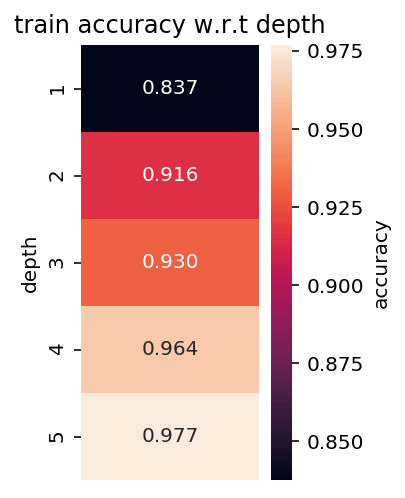

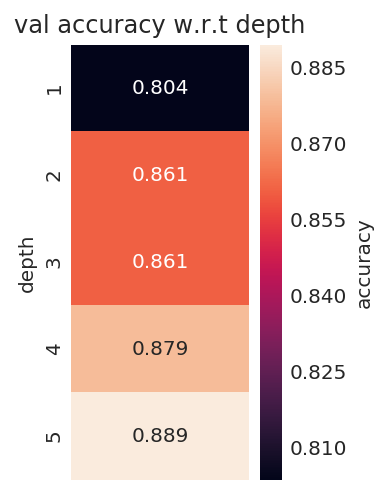

In [5]:
# 4) Draw heatmaps for result of grid search and find 
#    optimal D for validation set.
def draw_heatmap_linear(acc, acc_desc, depth_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=depth_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='depth')
    plt.title(acc_desc + ' w.r.t depth')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
#######FILL IN HERE #########
train_acc = clf.cv_results_['mean_train_score']
draw_heatmap_linear(train_acc.reshape(-1,1), 'train accuracy', D)

val_acc = clf.cv_results_['mean_test_score']
draw_heatmap_linear(val_acc.reshape(-1,1), 'val accuracy', D)

In [6]:
# 5) Use the optimal D to calculate the test accuracy.

#######FILL IN HERE #########
acc = tree_model.score(X_test,Y_test)
print("\n{:0.2f}%\n".format(acc))


0.83%



## 6 K-Nearest Neighbors

In [7]:
# 1) Load data.
from sklearn.model_selection import KFold
X_and_Y = np.load('ionosphere.npy').astype(np.float32) # Load data from file.
np.random.seed(0)
np.random.shuffle(X_and_Y)   # Shuffle the data.
X = X_and_Y[:, 0:-1]         # First column to second last column: Features (numerical values) 
Y = X_and_Y[:, -1]           # Last column: Labels (0 or 1)
print(X.shape, Y.shape)      # Check the shapes.

(351, 34) (351,)


In [8]:
# 2) Split the dataset into 2 parts: 
#    (a) Training set + Validation set  (80% of all data points)
#    (b) Test set                       (20% of all data points)

X_train_val = X[:int(0.8*len(X))] # Get features from train + val set.
X_test      = X[int(0.8*len(X)):] # Get features from test set.     
Y_train_val = Y[:int(0.8*len(Y))] # Get labels from train + val set.
Y_test      = Y[int(0.8*len(Y)):] # Get labels from test set.  
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(280, 34) (71, 34) (280,) (71,)


In [9]:
# 3) Implement the k-NN.
import math
import operator
from statistics import mode
class simple_KNeighborsClassifier(object):
    def __init__(self, k):
        """
        k-NN initialization.
            k: Number of nearest neighbors.
        """
        self.k = k
        
    def fit(self, X_train, Y_train):
        """
        k-NN fitting function.
            X_train: Feature vectors in training set.
            Y_train: Labels in training set.
        """
        self.X_train = X_train
        self.Y_train = Y_train

    def predict(self, X_pred):
        """
        k-NN prediction function.
            X_pred: Feature vectors in training set.
        Return the predicted labels for X_pred. Shape: (len(X_pred), )
        """
        #######FILL IN HERE #########
        Y_pred = []
        # Iterate through all X_pred features one at a time
        for i in range(len(X_pred)):
            dist = []
            # calc. euclidean dist. between one feat. vec and all feat. vecs in DF
            for j in range(len(self.X_train)):
                single_dist = (np.linalg.norm(X_pred[i] - self.X_train[j]))
                dist.append((j, single_dist)) 
            
            # Sort dist. in asscending order & pick labels for the k-min dist.
            dist.sort(key=lambda d: d[1])
            neighbors = np.array(dist[:self.k])
            neighbor_sum = 0
            for k_index in range(self.k):
                index_of_min = int(neighbors[k_index,0])
                neighbor_sum += self.Y_train[index_of_min]

            # The k-minimum mode will be used as pred. label for current feat. vec.  
            if neighbor_sum/self.k >= 0.5:
                Y_pred.append(1)
            else:
                Y_pred.append(0)
        return Y_pred

In [10]:
# 4) Implement the cross-validation.

def simple_cross_validation(X_train_val, Y_train_val, k, fold):
    """
    A simple cross-validation function for k-NN.
    
    X_train_val: Features for train and val set. 
                 Shape: (num of data points, num of features)
    Y_train_val: Labels for train and val set.
                 Shape: (num of data points,)
    k:           Parameter k for k-NN.
    fold:        The number of folds to do the cross-validation.
    
    Return the average accuracy on validation set.
    """
    val_acc_list = []
    train_acc_list = []
    kf = KFold(n_splits=fold)
    kf.get_n_splits(X_train_val)
    X_tr_folds = []
    X_val_folds = []
    Y_tr_folds = []
    Y_val_folds = []
    knn = simple_KNeighborsClassifier(k)
    for train_ind, val_ind in kf.split(X_train_val):
        X_tr_folds.append(X_train_val[train_ind])
        X_val_folds.append(X_train_val[val_ind])
        Y_tr_folds.append(Y_train_val[train_ind])
        Y_val_folds.append(Y_train_val[val_ind])
    for i in range(fold):
        #######FILL IN HERE #########
        knn.fit(X_tr_folds[i], Y_tr_folds[i])
        Y_tr_hat = knn.predict(X_tr_folds[i])
        Y_val_hat =knn.predict(X_val_folds[i])
        train_acc = sum(Y_tr_hat == Y_tr_folds[i])/len(Y_tr_folds[i])
        val_acc = sum(Y_val_hat == Y_val_folds[i])/len(Y_val_folds[i])
        val_acc_list.append(val_acc)
        train_acc_list.append(train_acc)
        
    return sum(val_acc_list) / len(val_acc_list), \
           sum(train_acc_list) / len(train_acc_list)

In [11]:
# 5) Implement the grid search function.

def simple_GridSearchCV_fit(X_train_val, Y_train_val, k_list, fold):
    """
    A simple grid search function for k with cross-validation in k-NN.
    
    X_train_val: Features for train and val set. 
                 Shape: (num of data points, num of features)
    Y_train_val: Labels for train and val set.
                 Shape: (num of data points,)
    k_list:      The list of k values to try.
    fold:        The number of folds to do the cross-validation.
    
    Return the val and train accuracy matrix of cross-validation. 
    All combinations of k are included in the array. 
    Shape: (len(k_list), )
    """
    val_acc_array = np.zeros(len(k_list))
    train_acc_array = np.zeros(len(k_list))
    for i in range(len(k_list)):
        val_acc_array[i], train_acc_array[i] = simple_cross_validation(
            X_train_val, Y_train_val, k_list[i], fold)
    return val_acc_array, train_acc_array

In [12]:
# 6) Perform grid search.

k_list = [1,2,3,4,5,6]
val_acc_array, train_acc_array = simple_GridSearchCV_fit(X_train_val, Y_train_val, k_list, 3)

/Users/brody/anaconda2/envs/env36/lib/python3.5/site-packages/numpy/linalg/linalg.py:2257: RuntimeWarning: invalid value encountered in sqrt
  ret = sqrt(sqnorm)


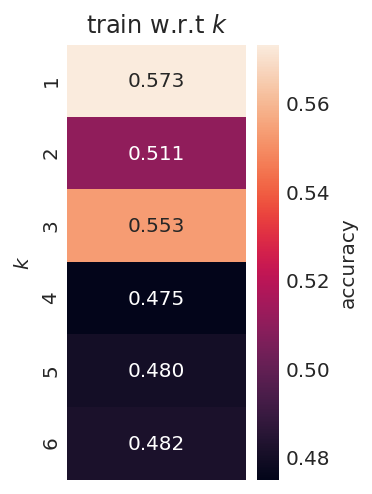

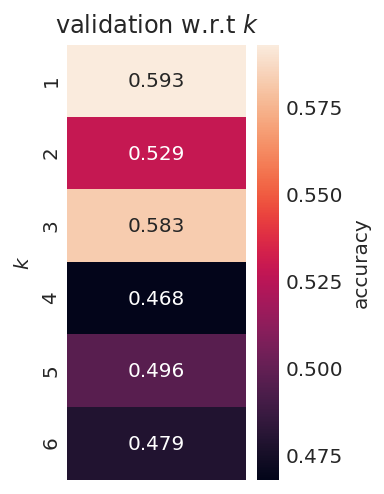

In [13]:
# 7) Draw heatmaps for result of grid search and find 
#    best k on validation set.

def draw_heatmap_knn(acc, acc_desc, k_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=k_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$k$')
    plt.title(acc_desc + ' w.r.t $k$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

#######FILL IN HERE #########
draw_heatmap_knn(train_acc_array.reshape(-1,1), 'train', k_list)
draw_heatmap_knn(val_acc_array.reshape(-1,1), 'validation', k_list)
# Hint:
# You can use the draw_heatmap_knn() to draw a heatmap to visualize 
# the accuracy w.r.t. k. Some demo code is given below as hint:

In [14]:
# 8) Use the best k to calculate the test accuracy.

#######FILL IN HERE #########
best_k_index = np.argmax(val_acc_array)
best_k = k_list[best_k_index]
print('best k: ', best_k)
clf = simple_KNeighborsClassifier(best_k)
clf.fit(X_train_val, Y_train_val)
Y_test_hat = clf.predict(X_test)
test_acc = sum(Y_test_hat == Y_test)/len(Y_test)
print('test acc: ', test_acc)


best k:  1
test acc:  0.7746478873239436


/Users/brody/anaconda2/envs/env36/lib/python3.5/site-packages/numpy/linalg/linalg.py:2257: RuntimeWarning: invalid value encountered in sqrt
  ret = sqrt(sqnorm)



## There's a weird issue with my version of numpy on my local machine. 
I ran this in Google Colab (colab.research.google.com) and it picked 2 as the best k and gave me a 95% accuracy. I'm not sure why I'm getting sub 

## 7 (Bonus) SVM